In [59]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils import model_utils, file_utils
from utils.callbacks import EvalCallback

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnvV2 as StockTradingEnv
from finrl.meta.preprocessor.preprocessors import data_split
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize

from finrl.plot import backtest_stats

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
HYPERPARAMETERS_PATH = r'..\experiments\ITUB4_012017_122018\TEST_ENV_V2_DDPG_0.5_TECH_FUND\tuning'

In [61]:
env_kwargs = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'env_train_kwargs.json'), 'r'))
args = json.load(open(os.path.join(HYPERPARAMETERS_PATH, 'command_line_args.json'), 'r'))
print('ENV KWARGS')
print(env_kwargs, '\n')
print('ARGS')
print(args)

# TEST_PATH = file_utils.uniquify(os.path.join('TESTS', '_'.join(args['tickers']), args['alg']))
# os.makedirs(TEST_PATH, exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'monitor_logs'), exist_ok=True)
# os.makedirs(os.path.join(TEST_PATH, 'tb_log'), exist_ok=True)

ENV KWARGS
{'stock_dim': 1, 'initial_amount': 100000, 'num_stock_shares': [0], 'buy_cost_pct': [0.001], 'sell_cost_pct': [0.001], 'reward_scaling': 1, 'state_space': 23, 'action_space': 1, 'tech_indicator_list': ['LPA', 'VPA', 'P/L', 'P/EBITDA', 'P/VPA', 'ROE', 'MARGEM_EBITDA', 'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'stochrsi_30', 'wr_30', 'vwma_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma'], 'turbulence_threshold': None, 'print_verbosity': 1000, 'perc_hmax': 0.5} 

ARGS
{'alg': 'DDPG', 'tickers': ['ITUB4.SA'], 'tuning_timesteps': 30000, 'train_timesteps': 200000, 'train_period': ['2017-01-01', '2018-12-31'], 'eval_period': ['2019-01-01', '2019-12-31'], 'trade_period': ['2020-01-01', '2021-12-31'], 'hmax': 0.5, 'use_ohlcv': False, 'initial_amount': 100000, 'n_trials': 10, 'n_repeats_by_trial': 3, 'output_path': '', 'metric_to_optimize': 'Sortino ratio', 'n_eval_episodes': 1, 'use_best_model': True, 'use_fundamental_indicators': True, 'use_tech

In [62]:
df_hyperparameters = pd.read_csv(os.path.join(HYPERPARAMETERS_PATH, 'hp_tuning_hist.csv'))
df_hyperparameters_group = df_hyperparameters.groupby(['trial', 'hyperparameters']).agg(['mean', 'std']).reset_index()
df_hyperparameters_group = df_hyperparameters_group.sort_values(('metric', 'mean'), ascending=False)

display(df_hyperparameters_group.head())

print('Best Trial: {} | Mean Metric: {:.4f} +- {:.4f}'.format(
    df_hyperparameters_group.iloc[0]['trial'][0], 
    df_hyperparameters_group.iloc[0][('metric', 'mean')],
    df_hyperparameters_group.iloc[0][('metric', 'std')],
    
    )
)

best_params = eval(df_hyperparameters_group.iloc[0]['hyperparameters'][0])
best_params = model_utils.load_params_from_store_format(best_params)

best_params

trial                                    hyperparameters    metric          
                                                                mean       std
1     1  {'gamma': 0.98, 'learning_starts': 2000, 'lear...  2.008262  0.997707
0     0  {'gamma': 0.99, 'learning_starts': 2000, 'lear...  0.402061       NaN

Best Trial: 1 | Mean Metric: 2.0083 +- 0.9977


{'gamma': 0.98,
 'learning_starts': 2000,
 'learning_rate': 0.0013089099557705246,
 'batch_size': 512,
 'buffer_size': 10000,
 'train_freq': (16, 'step')}

In [63]:
df = pd.read_pickle(os.path.join(HYPERPARAMETERS_PATH, 'dataset.pkl'))

train_set = data_split(df, args['train_period'][0], args['eval_period'][1])
eval_set = data_split(df, args['eval_period'][0], args['eval_period'][1])
trade_set = data_split(df, args['trade_period'][0], args['trade_period'][1])
# trade_set = data_split(df, '2021-01-01', '2021-12-31')

trade_set['date'] = pd.to_datetime(trade_set['date'])

print('Train\t', train_set['close'].iloc[-1] / train_set['close'].iloc[0] - 1)
print('Eval\t', eval_set['close'].iloc[-1] / eval_set['close'].iloc[0] - 1)
print('Trade\t', trade_set['close'].iloc[-1] / trade_set['close'].iloc[0] - 1)

Train	 0.8444842886948083
Eval	 0.05367300508995698
Trade	 -0.40524819935482803


100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
USANDO BEST MODEL
TIMESTEPS: 26675


,Model,Buy and Hold
Annual return,0.034949,-0.237034
Cumulative returns,0.068203,-0.405248
Annual volatility,0.378668,0.423340
Sharpe ratio,0.279698,-0.426274
Calmar ratio,0.097516,-0.524249
Stability,0.354600,0.001485
Max drawdown,-0.358392,-0.452140
Omega ratio,1.055693,0.927506
Sortino ratio,0.407603,-0.581388
Skew,NaN,NaN


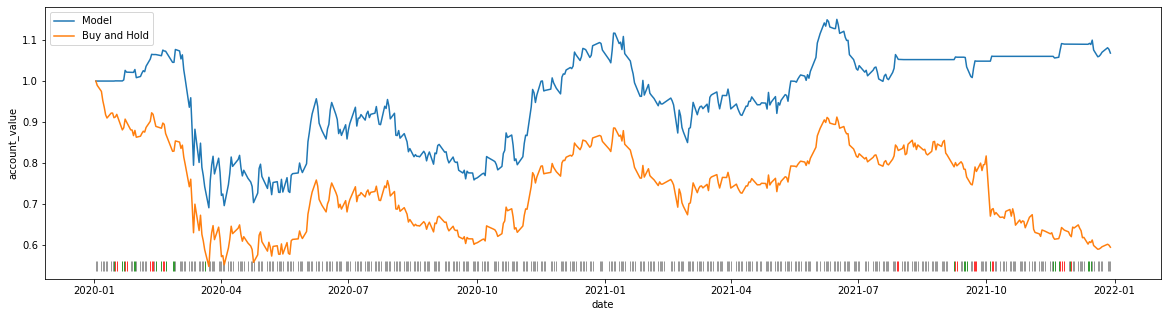

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
USANDO BEST MODEL
TIMESTEPS: 25220


,Model,Buy and Hold
Annual return,-0.055008,-0.237034
Cumulative returns,-0.102972,-0.405248
Annual volatility,0.388824,0.423340
Sharpe ratio,0.048035,-0.426274
Calmar ratio,-0.153463,-0.524249
Stability,0.233787,0.001485
Max drawdown,-0.358446,-0.452140
Omega ratio,1.008940,0.927506
Sortino ratio,0.069581,-0.581388
Skew,NaN,NaN


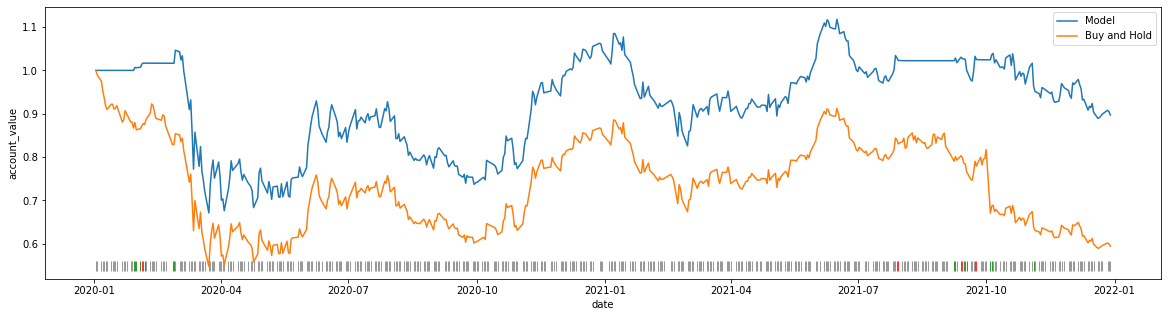

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
USANDO BEST MODEL
TIMESTEPS: 4850


,Model,Buy and Hold
Annual return,-0.008170,-0.237034
Cumulative returns,-0.015633,-0.405248
Annual volatility,0.378092,0.423340
Sharpe ratio,0.166779,-0.426274
Calmar ratio,-0.020972,-0.524249
Stability,0.270323,0.001485
Max drawdown,-0.389581,-0.452140
Omega ratio,1.033394,0.927506
Sortino ratio,0.241917,-0.581388
Skew,NaN,NaN


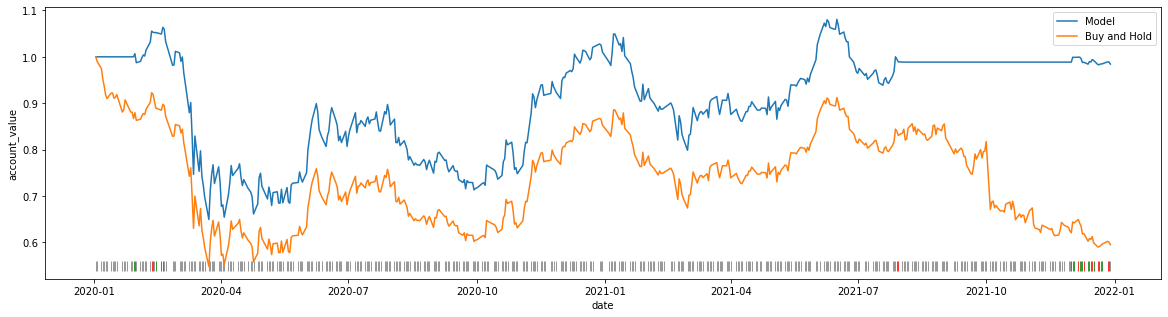

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
[Errno 2] No such file or directory: '..\\experiments\\ITUB4_012017_122018\\TEST_ENV_V2_DDPG_0.5_TECH_FUND\\tuning\\models\\TRIAL_1_REPEAT_3\\env_statistics_best'


In [64]:
a = 1

MODEL_TYPE = 'best' # ?'best' or 'final'

for b in range(0, 10):
    try:
        dataset = trade_set.copy() #data_split(trade_set, '2020-01-01', '2021-12-31').copy()
        dataset['date'] = pd.to_datetime(dataset['date'])

        e_eval_gym = StockTradingEnv(df=dataset, **env_kwargs)
        env_eval = DummyVecEnv([lambda: e_eval_gym])

        env_statistics_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'env_statistics_{MODEL_TYPE}'
        )

        env_eval = VecNormalize.load(
            env_statistics_path,
            env_eval,
        )
        env_eval.training = False
        env_eval.norm_reward = False

        best_model_path = os.path.join(
            HYPERPARAMETERS_PATH, 
            f'models',
            'TRIAL_{}_REPEAT_{}'.format(a, b),
            f'model_{MODEL_TYPE}.zip'
        )

        MODEL = model_utils.get_model(args['alg'])
        trained_model = MODEL.load(best_model_path, env_eval)

        print('USANDO BEST MODEL')
        print('TIMESTEPS:', trained_model.num_timesteps)


        account_memory, actions_memory, state_memory = model_utils.predict(
            trained_model, 
            env_eval, 
            True
        )

        account_temp = pd.DataFrame({
            'date': account_memory['date'],
            'account_value': dataset['close']
        })

        display(
            pd.concat([
                backtest_stats(account_value=account_memory),
                backtest_stats(account_value=account_temp)
            ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
        )

        cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
        cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

        actions_plot = np.where(
            actions_memory['actions'] > 0, 
            'green', 
            np.where(actions_memory['actions'] < 0,
                'red',
                'gray'
            )
        ).tolist() + ['gray']

        %matplotlib inline
        plt.figure(figsize=(20,5))
        sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
        sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

        sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
        plt.show()

    except Exception as e:
        print(e)
        break

## Retreino

In [65]:
from utils.file_utils import uniquify

In [66]:
def train_and_return_model(
    train_set,
    trade_set,
    env_kwargs,
    algorithm,
    train_episodes,
    model_params,
    best_model_path,
    return_best_model=False
):

    best_model_path = uniquify(best_model_path)

    os.makedirs(best_model_path, exist_ok=True)
    
    train_set = train_set.copy()

    e_train_gym = StockTradingEnv(
        df=train_set, 
        **env_kwargs
    )
    env_train = DummyVecEnv([lambda: e_train_gym])
    env_train = VecMonitor(
        env_train, 
        best_model_path
    )

    env_train = VecNormalize(
        env_train, 
        training=True,
        norm_obs=True, 
        norm_reward=True,
        gamma=model_params['gamma']
    )
    MODEL = model_utils.get_model(algorithm)
    model = MODEL(
        policy='MlpPolicy', 
        env=env_train,
        **model_params,
        verbose=False,
        seed=None,
        tensorboard_log=os.path.join(best_model_path)
    )

    eval_callback = EvalCallback(
        env_train, 
        n_eval_episodes=1,
        eval_freq=int(train_set.shape[0]),
        best_model_save_path=os.path.join(best_model_path),
        verbose=False
    )
    trained_model = model.learn(
        tb_log_name='tb',
        log_interval=1,
        total_timesteps=train_set.shape[0] * train_episodes,
        callback=[eval_callback],
        reset_num_timesteps=True
    )

    if not return_best_model:
        return trained_model
    else:
        e_trade_gym = StockTradingEnv(df=trade_set, **env_kwargs)
        env_trade = DummyVecEnv([lambda: e_trade_gym])
        env_trade = VecNormalize.load(
            os.path.join(best_model_path, 'env_statistics_best'), env_trade
        )
        env_trade.training = False
        env_trade.norm_reward = False

        MODEL = model_utils.get_model(args['alg'])
        best_model = MODEL.load(
            os.path.join(best_model_path, 'model_best.zip'), env_trade
        )
        return best_model

In [67]:
def predict_and_evaluate(model, save_path=None):
    print('MODEL TIMESTEPS:', model.num_timesteps)

    account_memory, actions_memory, state_memory = model_utils.predict(
        model, model.env, True
    )

    account_temp = pd.DataFrame({
        'date': account_memory['date'],
        'account_value': dataset['close']
    })

    display(
        pd.concat([
            backtest_stats(account_value=account_memory),
            backtest_stats(account_value=account_temp)
        ], axis=1).rename(columns={0: 'Model', 1: 'Buy and Hold'})
    )

    cum_return_model = (account_memory['account_value'].pct_change(1)+1).cumprod().fillna(1)
    cum_return_beh = (dataset['close'].pct_change(1)+1).cumprod().fillna(1)

    actions_plot = np.where(
        actions_memory['actions'] > 0, 
        'green', 
        np.where(
            actions_memory['actions'] < 0,
            'red',
            'gray'
        )
    ).tolist() + ['gray']

    %matplotlib inline
    plt.figure(figsize=(20,5))
    sns.lineplot(x=dataset['date'], y=cum_return_model, label='Model')
    sns.lineplot(x=dataset['date'], y=cum_return_beh, label='Buy and Hold')

    sns.scatterplot(x=dataset['date'], y=min(cum_return_model.min(), cum_return_beh.min()), c=actions_plot, marker='|', s=100)
    
    if save_path is not None:
        plt.save(os.path.join(save_path, 'returns.png'))
    plt.show()

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 727


,Model,Buy and Hold
Annual return,-0.000168,-0.237034
Cumulative returns,-0.000323,-0.405248
Annual volatility,0.000194,0.423340
Sharpe ratio,-0.869902,-0.426274
Calmar ratio,-0.473297,-0.524249
Stability,0.484718,0.001485
Max drawdown,-0.000355,-0.452140
Omega ratio,0.304696,0.927506
Sortino ratio,-0.940799,-0.581388
Skew,NaN,NaN


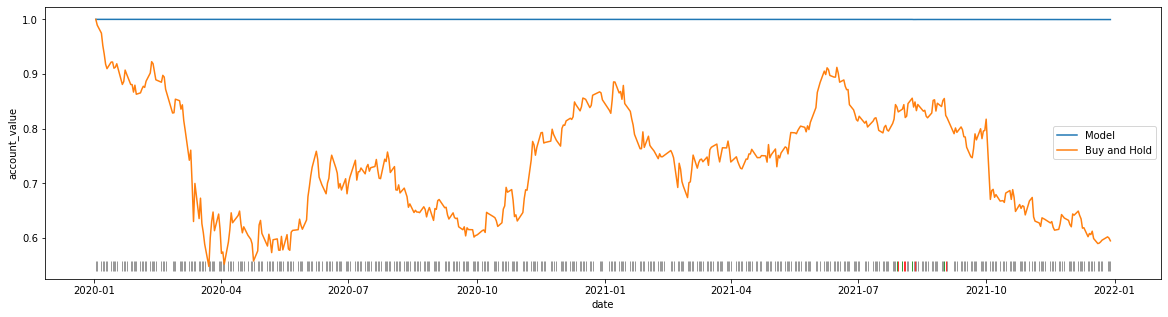

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,-0.096416,-0.237034
Cumulative returns,-0.176940,-0.405248
Annual volatility,0.340646,0.423340
Sharpe ratio,-0.125160,-0.426274
Calmar ratio,-0.284705,-0.524249
Stability,0.157990,0.001485
Max drawdown,-0.338654,-0.452140
Omega ratio,0.976926,0.927506
Sortino ratio,-0.170256,-0.581388
Skew,NaN,NaN


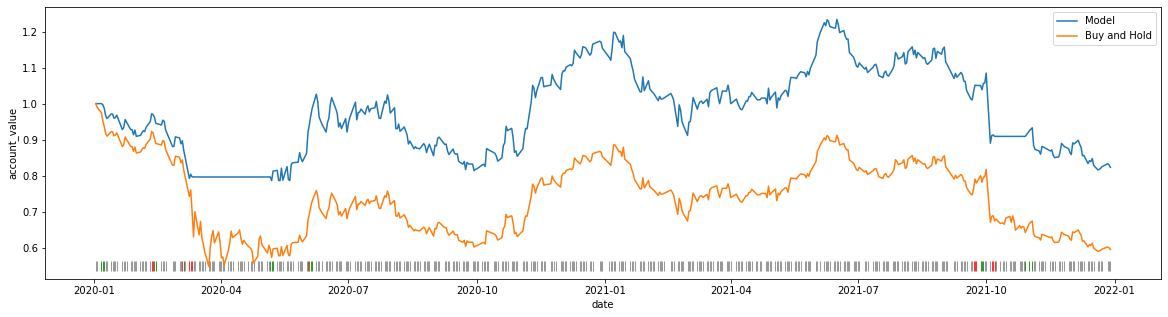

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.066164,-0.237034
Cumulative returns,0.130941,-0.405248
Annual volatility,0.326797,0.423340
Sharpe ratio,0.359153,-0.426274
Calmar ratio,0.276789,-0.524249
Stability,0.614086,0.001485
Max drawdown,-0.239043,-0.452140
Omega ratio,1.069063,0.927506
Sortino ratio,0.536630,-0.581388
Skew,NaN,NaN


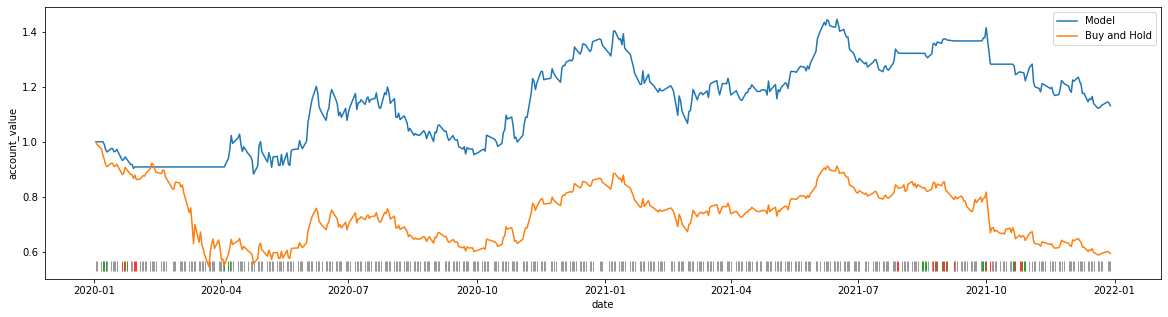

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,-0.200788,-0.237034
Cumulative returns,-0.349796,-0.405248
Annual volatility,0.422314,0.423340
Sharpe ratio,-0.318290,-0.426274
Calmar ratio,-0.494435,-0.524249
Stability,0.001975,0.001485
Max drawdown,-0.406095,-0.452140
Omega ratio,0.944965,0.927506
Sortino ratio,-0.435034,-0.581388
Skew,NaN,NaN


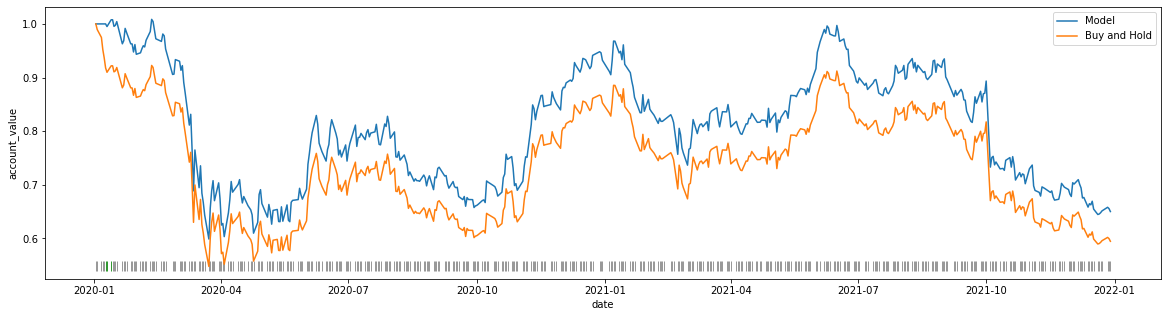

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 7270


,Model,Buy and Hold
Annual return,0.047765,-0.237034
Cumulative returns,0.093754,-0.405248
Annual volatility,0.296232,0.423340
Sharpe ratio,0.304982,-0.426274
Calmar ratio,0.199813,-0.524249
Stability,0.605172,0.001485
Max drawdown,-0.239049,-0.452140
Omega ratio,1.060322,0.927506
Sortino ratio,0.462712,-0.581388
Skew,NaN,NaN


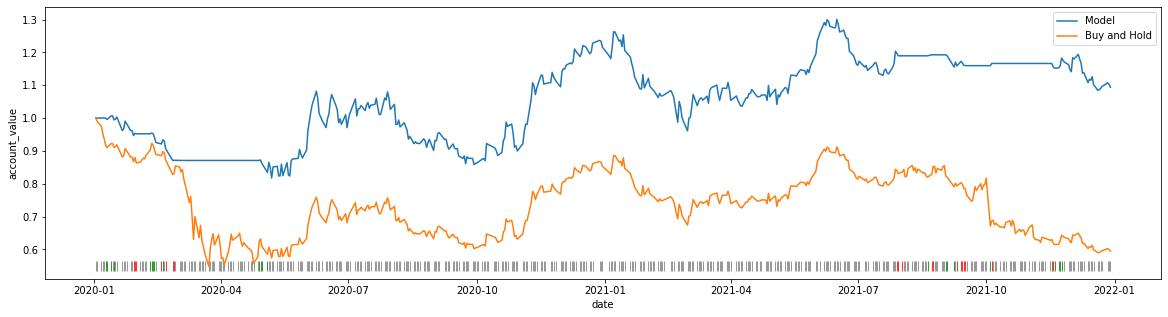

In [68]:
for i in range(5):

    best_model_path = os.path.join(
        Path(HYPERPARAMETERS_PATH).parent,
        'retrain_and_evaluation',
        str(i)
    )
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=10,
        model_params=best_params,
        return_best_model=True,
        best_model_path=best_model_path
    )

    predict_and_evaluate(model)



100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 26172


,Model,Buy and Hold
Annual return,-0.041305,-0.237034
Cumulative returns,-0.077822,-0.405248
Annual volatility,0.322330,0.423340
Sharpe ratio,0.029395,-0.426274
Calmar ratio,-0.146731,-0.524249
Stability,0.154288,0.001485
Max drawdown,-0.281505,-0.452140
Omega ratio,1.005831,0.927506
Sortino ratio,0.043045,-0.581388
Skew,NaN,NaN


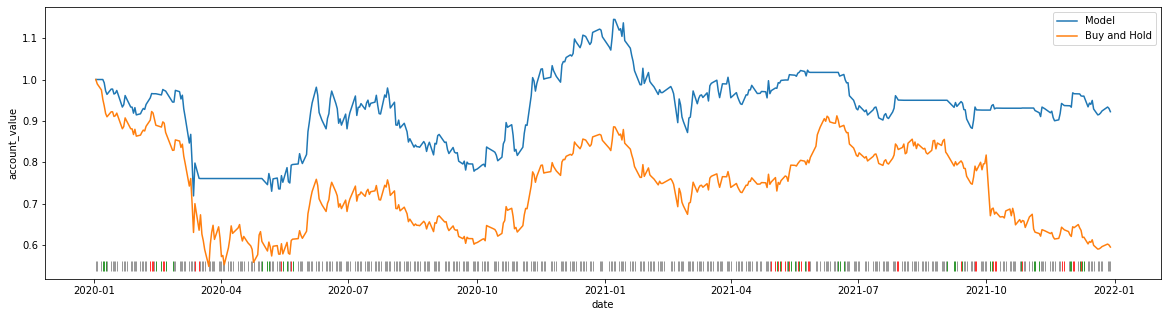

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>
MODEL TIMESTEPS: 31261


,Model,Buy and Hold
Annual return,-0.169233,-0.237034
Cumulative returns,-0.299595,-0.405248
Annual volatility,0.400558,0.423340
Sharpe ratio,-0.263417,-0.426274
Calmar ratio,-0.413547,-0.524249
Stability,0.010001,0.001485
Max drawdown,-0.409222,-0.452140
Omega ratio,0.953190,0.927506
Sortino ratio,-0.370217,-0.581388
Skew,NaN,NaN


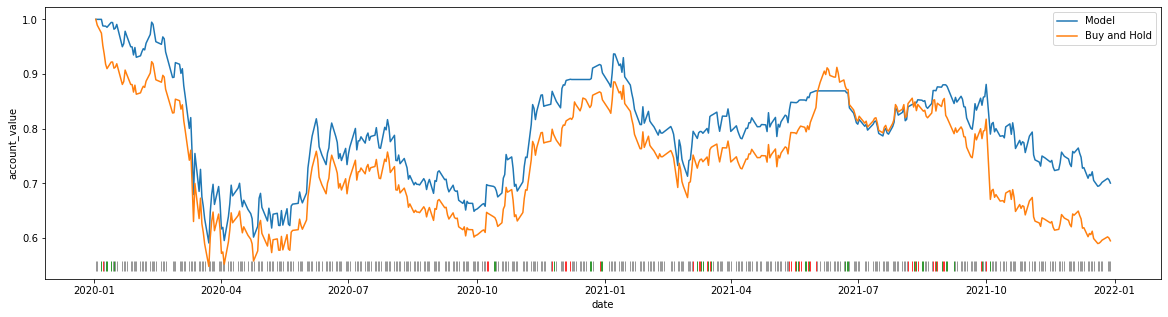

100000
<class 'int'>
100000
<class 'numpy.float64'>
0.5
<class 'float'>


In [69]:
for i in range(5):
    model = train_and_return_model(
        train_set=train_set,
        trade_set=trade_set,
        env_kwargs=env_kwargs,
        algorithm=args['alg'],
        train_episodes=50,
        model_params=best_params,
        return_best_model=True,
        best_model_path=best_model_path
    )

    predict_and_evaluate(model)